<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [4]</a>'.</span>

In [1]:
# | code-summary: code -- load dependencies and data and select parameters

from compmemlearn.fitting import generate_objective_function
from compmemlearn.datasets import events_metadata, simulate_df, generate_trial_mask
from scipy.optimize import differential_evolution
from numba.typed import List, Dict
from numba.core import types
from numba import njit
from psifr import fr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import importlib
import os

lb = np.finfo(float).eps
ub = 1 - np.finfo(float).eps

figure_caption = """Distribution of log-likelihood scores of recall sequences exhibited by each subject in dataset under each considered model."""

section_tag = "LohnasCondition1"

data_path = "../data/LohnasKahana2014.csv"
results_path = "results/"
trial_query = "condition == 1"

model_paths = ["compmemlearn.models.Classic_CMR", "compmemlearn.models.Instance_CMR", "compmemlearn.models.Dual_Instance_CMR"]

model_names = ["PrototypeCMR", "InstanceCMR", "Dual Memory ICMR"]

free_parameters = [
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "choice_sensitivity",
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        #    'choice_sensitivity',
        "context_sensitivity",
        #    'feature_sensitivity'
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        #    'choice_sensitivity',
        "context_sensitivity",
        #    'feature_sensitivity'
        "delay_drift_rate",
    ],
]

bounds = [
    [
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, 100],
        [lb, 100],
        [lb, ub],
        [lb, 10],
        [lb, 10],
        [lb, ub],
    ],
    [
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, 100],
        [lb, 100],
        [lb, ub],
        [lb, 10],
        [lb, 10],
        [lb, ub],
    ],
    [
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, 100],
        [lb, 100],
        [lb, ub],
        [lb, 10],
        [lb, 10],
        [lb, ub],
    ],
]

fixed_parameters = [
    {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 
         'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
    {"choice_sensitivity": 1, "feature_sensitivity": 1, 'mfc_familiarity_scale': 0, 
         'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0},
    {"choice_sensitivity": 1, "feature_sensitivity": 1, 'mfc_familiarity_scale': 0, 
         'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0},
]

analysis_paths = ['compmemlearn.analyses.plot_spc', 'compmemlearn.analyses.plot_crp', 'compmemlearn.analyses.plot_pfr']
analysis_names = ['spc', 'crp', 'pfr']

experiment_count = 100


In [2]:
# Parameters
data_path = "../data/Murdock1962.csv"
trial_query = "`list length` == 40"
model_paths = [
    "compmemlearn.models.Base_CMR",
    "compmemlearn.models.Dual_ICMR",
]
model_names = ["PrototypeCMR", "ICMR_2_0_1"]
free_parameters = [
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "choice_sensitivity",
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "choice_sensitivity",
        "delay_drift_rate",
    ],
]
bounds = [
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
    ],
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
    ],
]
fixed_parameters = [
    {},
    {"feature_sensitivity": 1, "context_sensitivity": 1, "learning_order": 1},
]
section_tag = "Murdock1962_LL40"

In [3]:
#| code-summary: code -- test that specified parameters are valid
#| output: false

events = pd.read_csv(data_path)

trials, list_lengths, presentations = events_metadata(events)
trial_mask = generate_trial_mask(events, trial_query)

# import models from specified source
models = []
for i in range(len(model_paths)):
    module_name, model_name = model_paths[i].rsplit('.',1) #TODO: add handling for case with no `.`
    module = importlib.import_module(module_name)
    models.append(getattr(module, model_name))

# import analyses from specified source
analyses = []
for i in range(len(analysis_paths)):
    module_name, analysis_name = analysis_paths[i].rsplit('.',1) #TODO: add handling for case with no `.`
    module = importlib.import_module(module_name)
    analyses.append(getattr(module, analysis_name))

# make sure model initializes with provided parameters and boundaries
for model_index, model_class in enumerate(models):

    @njit(fastmath=True, nogil=True)
    def init_model(item_count, presentation_count, parameters):
        return model_class(item_count, presentation_count, parameters)

    subject_specific_trial_mask = np.logical_and(
                generate_trial_mask(events, f'subject == {pd.unique(events.subject)[0]}'), trial_mask)

    cost_function = generate_objective_function(
        [trials[i][subject_specific_trial_mask[i]] for i in range(len(trials))],
        [presentations[i][subject_specific_trial_mask[i]] for i in range(len(presentations))],
        list_lengths,
        init_model,
        fixed_parameters[model_index],
        free_parameters[model_index],
    )
    print(cost_function)
    
    for boundary_index in range(2):
        x = np.array([each[boundary_index] for each in bounds[model_index]])
        assert(len(x) == len(free_parameters[model_index])) 

        # parameter configuration
        parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
        for name, value in fixed_parameters[model_index].items():
            parameters[name] = value
        for i in range(len(free_parameters[model_index])):
                parameters[free_parameters[model_index][i]] = x[i]

        model = init_model(20, 20, parameters)
        model.experience(model.items)
        model.free_recall()

        print(cost_function(x))
print('dependencies and parameters validated')
#print(trial_index, recall_index, recall, trial, likelihood[trial_index, recall_index], model.outcome_probabilities())

<function murdock_objective_function.<locals>.objective_function at 0x0000020E0ECA98B0>
4732.215174454715
7073.5440937229905
<function murdock_objective_function.<locals>.objective_function at 0x0000020E10BC7040>
4732.215174454715
7073.5440937229905
dependencies and parameters validated


<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [4]:
# | code-summary: code -- 1) fit each model class participant-by-participant
# | output: false

for model_index, model_class in enumerate(models):

    # load individual fits for this model and section tag from csv if they exist
    if os.path.isfile(results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index])):
        pd.read_csv(results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index]))
        print('individual fits for {} with tag {} already exist'.format(model_names[model_index], section_tag))

    # otherwise, fit each participant individually
    else:
        model_individual_fits = []

        @njit(fastmath=True, nogil=True)
        def init_model(item_count, presentation_count, parameters):
            return model_class(item_count, presentation_count, parameters)

        for subject in pd.unique(events.subject):
            print(f'{model_names[model_index]}, Subject {subject}')

            subject_specific_trial_mask = np.logical_and(
                generate_trial_mask(events, f'subject == {subject}'), trial_mask)
            
            try:
                # cost function to be minimized
                # ours scales inversely with the probability that the data could have been
                # generated using the specified parameters and our model
                cost_function = generate_objective_function(
                    [trials[i][subject_specific_trial_mask[i]] for i in range(len(trials))],
                    [presentations[i][subject_specific_trial_mask[i]] for i in range(len(presentations))],
                    list_lengths,
                    init_model,
                    fixed_parameters[model_index],
                    free_parameters[model_index],
                )
            except ValueError:
                continue

            fit_result =  differential_evolution(cost_function, bounds[model_index], disp=False)

            fitted_parameters = {
                'subject': subject, 'trial_count': np.sum(subject_specific_trial_mask), 
                'likelihood': fit_result.fun, 'model': model_names[model_index]
                }
            for i in range(len(fit_result.x)):
                fitted_parameters[free_parameters[model_index][i]] = fit_result.x[i]
            for key in fixed_parameters[model_index]:
                fitted_parameters[key] = fixed_parameters[model_index][key]

            model_individual_fits.append(pd.DataFrame.from_dict(fitted_parameters, orient='index').T)
            print(model_individual_fits[-1]['likelihood'][0])

        model_individual_fits = pd.concat(model_individual_fits, ignore_index=True)
        model_individual_fits.to_csv(
            results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index]), index=False)

individual fits for PrototypeCMR with tag Murdock1962_LL40 already exist
ICMR_2_0_1, Subject 1
1440.9913929744407
ICMR_2_0_1, Subject 2
2251.928492920323
ICMR_2_0_1, Subject 3
2183.7671936825873
ICMR_2_0_1, Subject 4
1633.9693154261156
ICMR_2_0_1, Subject 5
2075.8987122478748
ICMR_2_0_1, Subject 6
1734.4757839866106
ICMR_2_0_1, Subject 7
2300.9890765273676
ICMR_2_0_1, Subject 8
2069.3035581834274
ICMR_2_0_1, Subject 9
1706.3556715466411
ICMR_2_0_1, Subject 10
2072.326942001019
ICMR_2_0_1, Subject 11
1785.8371421793588
ICMR_2_0_1, Subject 12
1797.2608968751574
ICMR_2_0_1, Subject 13
1920.759506028522
ICMR_2_0_1, Subject 14
2077.4446247680416
ICMR_2_0_1, Subject 15
2127.288193832712


Text(-0.30555555555555536, 0.5, 'Individual Log-Likelihood')

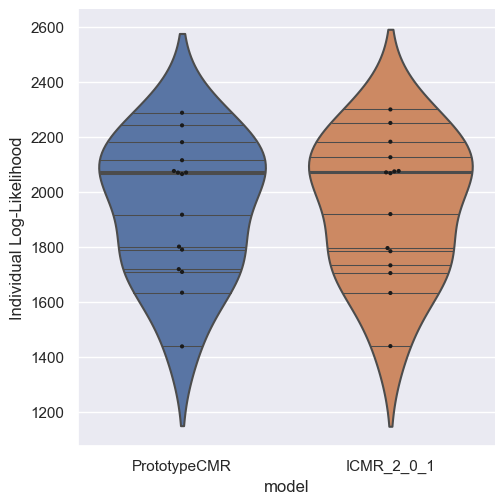

In [5]:
#| code-summary: code -- 3) plot distribution of log-likelihoods across individual subjects

plt.style.use('default')
sns.set(style="darkgrid")

# build individual fits df concatenating results from each model
individual_fits = []
for model_index, model_class in enumerate(models):
    individual_fits.append(
        pd.read_csv(results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index])))
individual_fits = pd.concat(individual_fits, ignore_index=True)

# plot distribution of log-likelihoods across individual subjects
g = sns.catplot(x='model', y='likelihood', data=individual_fits, kind='violin', inner='stick')
sns.swarmplot(x="model", y="likelihood", data=individual_fits, color="k", size=3, ax=g.ax)
g.ax.set_ylabel('Individual Log-Likelihood')
#plt.savefig(results_path + 'individual_{}.pdf'.format(section_tag), bbox_inches="tight")

In [6]:
individual_fits

,subject,trial_count,likelihood,model,encoding_drift_rate,start_drift_rate,recall_drift_rate,shared_support,item_support,learning_rate,primacy_scale,primacy_decay,stop_probability_scale,stop_probability_growth,choice_sensitivity,delay_drift_rate,feature_sensitivity,context_sensitivity,learning_order
0,1,80,1439.977320,PrototypeCMR,0.656826,2.547775e-03,0.411789,0.058476,1.000000,8.020997e-02,3.109715e+01,45.490067,0.015647,0.439628,2.308760,9.751080e-01,NaN,NaN,NaN
1,2,80,2243.230608,PrototypeCMR,0.585183,2.220446e-16,0.806821,0.335666,0.513545,1.930270e-01,1.122691e+00,43.511889,0.003419,0.426171,6.632966,1.000000e+00,NaN,NaN,NaN
2,3,80,2182.048620,PrototypeCMR,0.602375,3.189114e-04,0.773257,0.359251,1.000000,1.514324e-01,4.504315e+00,58.549567,0.007222,0.368395,6.596734,9.783665e-01,NaN,NaN,NaN
3,4,80,1635.152261,PrototypeCMR,0.802413,2.481684e-02,0.745017,0.040296,1.000000,1.568809e-01,1.064604e+01,41.164028,0.027769,0.338386,1.409290,7.165171e-07,NaN,NaN,NaN
4,5,80,2077.405990,PrototypeCMR,0.622999,6.608851e-03,0.765959,0.363170,0.324665,2.036514e-01,1.036536e+00,25.311704,0.016139,0.287965,6.875121,9.926661e-01,NaN,NaN,NaN
5,6,80,1720.611423,PrototypeCMR,0.866374,2.220446e-16,0.883496,0.436593,1.000000,4.222770e-01,2.220446e-16,50.132049,0.018325,0.347531,6.393150,2.220446e-16,NaN,NaN,NaN
6,7,80,2289.014508,PrototypeCMR,0.748142,1.315755e-01,0.773998,0.284229,1.000000,3.298499e-01,3.475781e+00,79.697195,0.010444,0.317467,4.660853,2.220446e-16,NaN,NaN,NaN
7,8,80,2066.246991,PrototypeCMR,0.545842,2.220446e-16,0.666632,0.335427,0.667325,1.066918e-01,1.324247e+00,47.649797,0.011416,0.365688,6.387391,1.000000e+00,NaN,NaN,NaN
8,9,80,1710.503652,PrototypeCMR,0.711844,2.220446e-16,0.854809,0.106056,1.000000,2.270734e-01,3.460713e+00,54.256689,0.021032,0.312509,2.721171,1.921410e-02,NaN,NaN,NaN
9,10,80,2071.878505,PrototypeCMR,0.581406,2.550183e-02,0.885795,0.098543,1.000000,7.014785e-02,1.453939e+01,49.022497,0.017089,0.296375,2.418434,8.759890e-01,NaN,NaN,NaN


In [7]:
#| code-summary: display markdown rendering of summary table
#| echo: false
#| input: false
#| output: asis

summary_table = pd.DataFrame(group.describe().rename(columns={'likelihood':name}).squeeze()
            for name, group in individual_fits[['model', 'likelihood']].groupby('model')).T.to_markdown()

print("""::: {{#fig-{section_tag}fits layout-nrow=2 layout-valign="center"}}

![]({results_path}individual_{section_tag}.pdf)

{summary_table}

{individual_fits_caption}
:::""".format(section_tag=section_tag, summary_table=summary_table, individual_fits_caption=figure_caption, results_path=results_path))

::: {#fig-Murdock1962_LL40fits layout-nrow=2 layout-valign="center"}

![](results/individual_Murdock1962_LL40.pdf)

|       |   ICMR_2_0_1 |   PrototypeCMR |
|:------|-------------:|---------------:|
| count |       15     |         15     |
| mean  |     1945.24  |       1942.46  |
| std   |      250.328 |        247.565 |
| min   |     1440.99  |       1439.98  |
| 25%   |     1760.16  |       1756.13  |
| 50%   |     2069.3   |       2066.25  |
| 75%   |     2102.37  |       2096.97  |
| max   |     2300.99  |       2289.01  |

Distribution of log-likelihood scores of recall sequences exhibited by each subject in dataset under each considered model.
:::


In [8]:
#| code-summary: perform t-tests on individual-level fits
#| output: false
 
from scipy.stats import ttest_rel
import itertools

for combination in itertools.combinations(pd.unique(individual_fits.model), 2):

    print(combination)
    print(ttest_rel(individual_fits[individual_fits.model == combination[0]].likelihood, individual_fits[individual_fits.model == combination[1]].likelihood, alternative='two-sided'))
    print(ttest_rel(individual_fits[individual_fits.model == combination[0]].likelihood, individual_fits[individual_fits.model == combination[1]].likelihood, alternative='less'))
    print(ttest_rel(individual_fits[individual_fits.model == combination[0]].likelihood, individual_fits[individual_fits.model == combination[1]].likelihood, alternative='greater'))
    print()

('PrototypeCMR', 'ICMR_2_0_1')
Ttest_relResult(statistic=-1.7211595718575219, pvalue=0.10723472974314167)
Ttest_relResult(statistic=-1.7211595718575219, pvalue=0.05361736487157084)
Ttest_relResult(statistic=-1.7211595718575219, pvalue=0.9463826351284291)



In [9]:
for combination in itertools.combinations(pd.unique(individual_fits.model), 2):

    print(combination)
    print(np.mean(individual_fits[individual_fits.model == combination[0]].likelihood.values < individual_fits[individual_fits.model == combination[1]].likelihood.values), 
        np.mean(individual_fits[individual_fits.model == combination[1]].likelihood.values < individual_fits[individual_fits.model == combination[0]].likelihood.values))

    print(np.sum(individual_fits[individual_fits.model == combination[0]].likelihood.values < individual_fits[individual_fits.model == combination[1]].likelihood.values), 
        np.sum(individual_fits[individual_fits.model == combination[1]].likelihood.values < individual_fits[individual_fits.model == combination[0]].likelihood.values))

    print()

('PrototypeCMR', 'ICMR_2_0_1')
0.6666666666666666 0.3333333333333333
10 5



In [10]:
def model_weights(positive_log_likelihoods, number_parameters, N):
    AIC = 2 * positive_log_likelihoods + 2 * number_parameters
    AICc = AIC #+ (2*np.power(number_parameters, 2) + 2 * number_parameters) / (N - number_parameters - 2)
    AICd = AIC - np.min(AICc)
    #return AICd
    AICw = np.exp(-.5 * AICd) / np.sum(np.exp(-.5 * AICd))
    return AICw

aicw = {'Model': [], 'Subject': [], 'AICw': []}

total_nlns = np.zeros(len(models))
for subject_index, subject in enumerate(pd.unique(events.subject)):

    subject_specific_trial_mask = np.logical_and(
                    generate_trial_mask(events, f'subject == {subject}'), trial_mask)

    nlnLs = []
    for model_index, model_class in enumerate(models):
        nlnLs.append(
            individual_fits[individual_fits.model == model_names[model_index]].likelihood.values[subject_index])
    nlnLs = np.array(nlnLs)
    total_nlns += nlnLs
    
    weights = model_weights(nlnLs, len(free_parameters[model_index]), np.sum(subject_specific_trial_mask))
    #print(weights)
    for model_index, model_class in enumerate(models):
        aicw['Model'].append(model_names[model_index])
        aicw['Subject'].append(subject)
        aicw['AICw'].append(weights[model_index])

aicw = pd.DataFrame(data=aicw)
total_aicw = model_weights(total_nlns, len(free_parameters[model_index]), np.sum(trial_mask))
print(total_aicw)

[1.00000000e+00 7.92927832e-19]


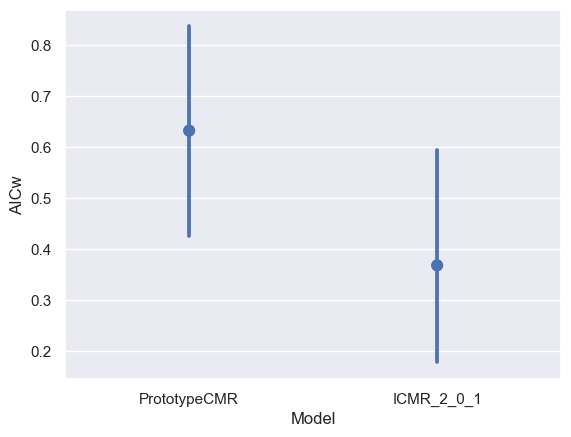

In [11]:
import seaborn as sns
sns.set_theme(style="darkgrid")
x = sns.pointplot(x="Model", y="AICw", data=aicw, join=False)

plt.show()

In [12]:
sns.set(style='darkgrid')

# for each unique list length
if not (isinstance(list_lengths, list) or isinstance(list_lengths, List)): 
    list_lengths = [list_lengths]

for list_length in list_lengths:

    #fig, axes = plt.subplots(nrows=len(models), ncols=3, figsize=(15, int(4*len(models))), sharey=False)
    
    # for each unique model
    for model_index, model_class in enumerate(models):

        # load sim_df from csv if it exists
        sim_df_path = results_path + '{}_{}_ll{}_sim_df.csv'.format(section_tag, model_names[model_index], list_length)
        if os.path.isfile(sim_df_path):
            sim_df = pd.read_csv(sim_df_path)
            print('sim_df for {} with tag {} and list length {} already exists'.format(model_names[model_index], section_tag, list_length))

        # otherwise, generate it
        else:

            # for each unique matching entry in individual df
            sim_dfs = []
            for subject in pd.unique(individual_fits.subject):
                
                fit_result = individual_fits.query(f'subject == {subject} & model == "{model_names[model_index]}"')

                # configure model based on specified parameters
                fitted_parameters = Dict.empty(
                    key_type=types.unicode_type, value_type=types.float64
                )
                for i in range(len(free_parameters[model_index])):
                    fitted_parameters[free_parameters[model_index][i]] = fit_result[free_parameters[model_index][i]].values[0]
                for key in fixed_parameters[model_index]:
                    fitted_parameters[key] = fixed_parameters[model_index][key]

                # simulate df based on specified trial_count and experiment_count
                #model = model_class(list_length, list_length, fitted_parameters)
                sim_dfs.append(simulate_df_from_events(model, fit_result['trial_count'].values[0] * experiment_count))
                sim_dfs[-1].list = sim_dfs[-1].subject
                sim_dfs[-1].subject = subject

            # concatenate simulations into one dataframe
            sim_df = pd.concat(sim_dfs)

            # save sim_df to csv
            sim_df.to_csv(results_path +'{}_{}_ll{}_sim_df.csv'.format(section_tag, model_names[model_index], list_length), index=False)

        # design general filter for analysis df
        if len(list_lengths) > 1:
            analysis_query = trial_query + f' & list_length == {list_length}'
        else:
            analysis_query = trial_query

        # generate plot for each parametrized analysis and model
        for analysis_index, analysis_function in enumerate(analyses):
            analysis_name = analysis_names[analysis_index]
            axis = analysis_function(
                [events, sim_df], analysis_query, contrast_name="source", labels=["data", model_names[model_index]])
            plt.savefig(results_path+'{}_{}_ll{}_{}.pdf'.format(section_tag, model_names[model_index], list_length, analysis_name), bbox_inches="tight")

NameError: name 'simulate_df_from_events' is not defined